In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [49]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
train_data.describe(include = "all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [52]:
# Split train data in numerical and categorical data

num_data = train_data[['Age', 'SibSp', 'Parch', 'Fare']]
cat_data = train_data[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

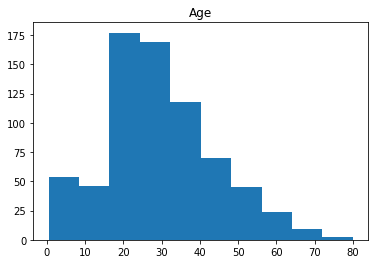

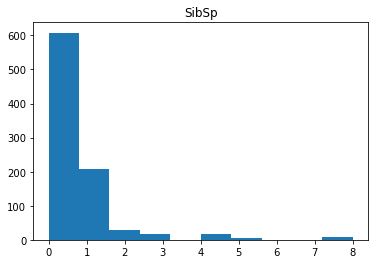

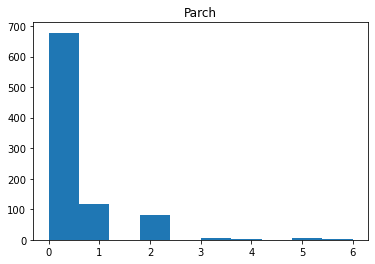

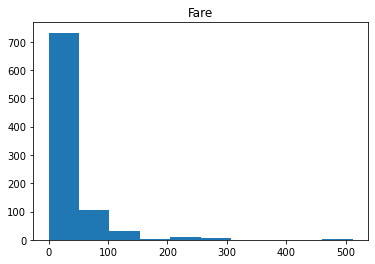

In [53]:
# Visulize the numerical data

for col in num_data.columns:
    plt.hist(num_data[col])
    plt.title(col)
    plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

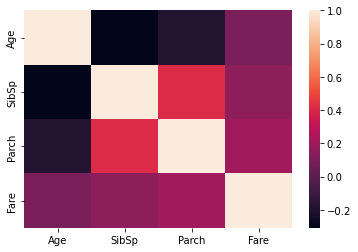

In [54]:
# Check the correlation between the numerical data

print(num_data.corr())
sns.heatmap(num_data.corr())

In [55]:
# Compare survival rate across the average Age, SibSp, Parch and Fare

pd.pivot_table(train_data, index = 'Survived', values = ['Age', 'SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [56]:
train_data[['SibSp', 'Survived']].groupby('SibSp', as_index=False).mean().sort_values(by='Survived', ascending=False)
train_data[['Parch', 'Survived']].groupby('Parch', as_index=False).mean().sort_values(by='Survived', ascending=False)

# Make a new column of the whole family and check the survival rate by size of families

train_data['Family'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data[['Family', 'Survived']].groupby('Family', as_index=False).mean().sort_values(by='Survived', ascending=False)


,Family,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


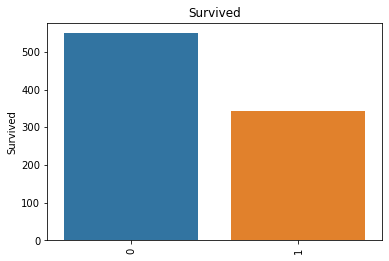

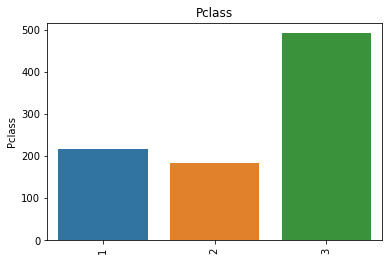

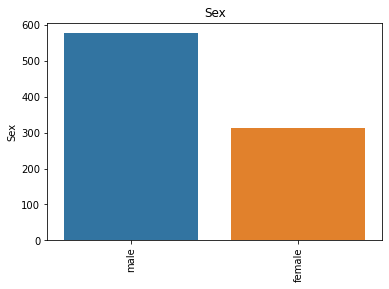

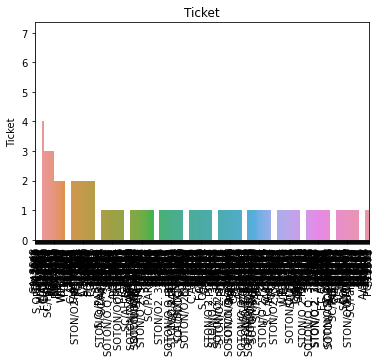

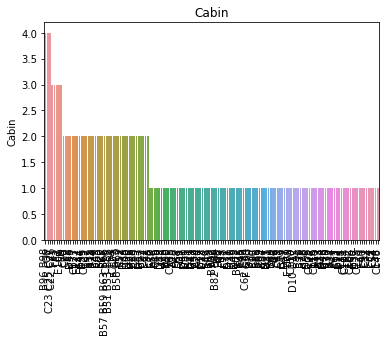

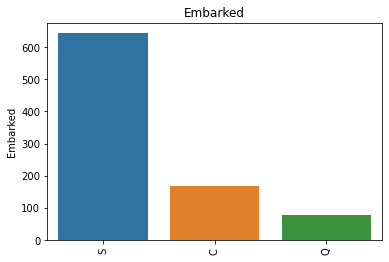

In [57]:
# Visulize the categorical data

for col in cat_data.columns:
    sns.barplot(data=cat_data, x=cat_data[col].value_counts().index, y=cat_data[col].value_counts())
    plt.title(col)
    plt.xticks(rotation='vertical')
    plt.show()

In [58]:
# Compare Survived and each of the categorical variables

print(pd.pivot_table(train_data, values='Ticket', index='Survived', columns='Pclass', aggfunc='count'), '\n')
print(pd.pivot_table(train_data, values='Ticket', index='Survived', columns='Sex', aggfunc='count'), '\n')
print(pd.pivot_table(train_data, values='Ticket', index='Survived', columns='Embarked', aggfunc='count'), '\n')

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119 

Sex       female  male
Survived              
0             81   468
1            233   109 

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217 



In [59]:
# Check the theory that more women survived

men = train_data.loc[train_data['Sex'] == 'male']
rate_men = sum(men['Survived'] == 1) / len(men)
print('Percentage of all men who survived =', round((rate_men) * 100))
women = train_data.loc[train_data['Sex'] == 'female']
rate_women = sum(women['Survived'] == 1) / len(women)
print('Percentage of all women who survived =', round((rate_women) * 100))

Percentage of all men who survived = 19
Percentage of all women who survived = 74


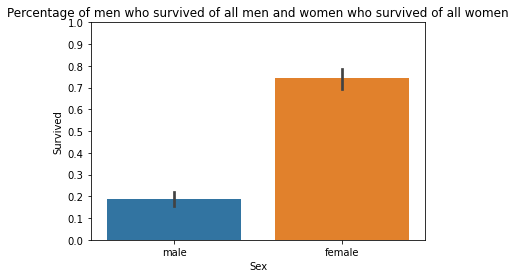

In [60]:
ax = sns.barplot(data=train_data, x='Sex', y='Survived')
plt.title('Percentage of men who survived of all men and women who survived of all women')
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

Mr        517
Miss      184
Mrs       125
Master     40
Rare       23
Name: Title, dtype: int64


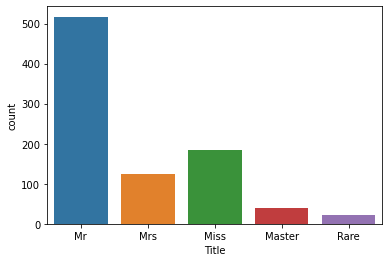

0    0
1    0
2    1
3    0
4    1
Name: IsAlone, dtype: int64


In [62]:
# Data preprocessing 

# Choose the relevant features

features = ['Pclass', 'Sex', 'Survived', 'Fare_Range', 'Embarked', 'Title', 'IsAlone', 'Age_Range']

# Locate the rows which have the same values in the 'SibSp', 'Parch' and 'Pclass" columns and fill the missing values
# with the median of these rows
# If no rows are found fill the missing value with the median of the entire 'Age' column

pd.options.mode.chained_assignment = None

age_nan_indices = list(train_data[train_data['Age'].isnull()].index)

for index in age_nan_indices:
    median_age = train_data['Age'].median()
    predict_age = train_data['Age'][(train_data['SibSp'] == train_data.iloc[index]['SibSp'])
                                    & (train_data['Parch'] == train_data.iloc[index]['Parch'])
                                    & (train_data['Pclass'] == train_data.iloc[index]['Pclass'])].median()
                                       
    if np.isnan(predict_age):
        train_data['Age'].iloc[index] = median_age
    else:
        train_data['Age'].iloc[index] = predict_age
                                       
# Remove missing values of 'Embarked' column

train_data.dropna(subset=['Embarked'], inplace=True)

# Feature engeneering

# Make 'Fare_Range' column

train_data['Fare_Range'] = pd.cut(train_data['Fare'], bins=[0,7.91,14.45,31,120], 
                                  labels=['Low_fare','median_fare', 'Average_fare','high_fare'])

# Make 'Title' column

train_data['Title'] = [name.split(',')[1].split('.')[0].strip() for name in train_data['Name']]
train_data['Title'] = train_data['Title'].replace(['Jonkheer', 'Dr', 'Rev', 'Major', 'Col', 'Capt', 'Don', 
                                                   'the Countess', 'Lady', 'Sir'], 'Rare')  
train_data['Title'] = train_data['Title'].replace('Mme', 'Mrs') 
train_data['Title'] = train_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
print(train_data['Title'].value_counts())
sns.countplot(data = train_data, x = 'Title')
plt.show()

# Make 'IsAlone' column

train_data['IsAlone'] = 0
train_data.loc[train_data['Family'] == 1, 'IsAlone'] = 1
print(train_data['IsAlone'].head())

# Make 'Age_range' column

train_data['Age_Range'] = pd.cut(train_data['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])


# Convert categorical variables into indicator variables using pd.get_dummies

data = pd.get_dummies(train_data[features])


# Assign X and y

X = data.drop(columns=['Survived'])
y = data['Survived']

In [32]:
# Split the data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [34]:
# Compare models

gnb = GaussianNB()
cv = cross_val_score(gnb, X_train, y_train, cv=5)
print(cv)
print('Naive Bayes CV mean =', '{:.3f}'.format(cv.mean()), '\n')

lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr, X_train, y_train, cv=5)
print(cv)
print('Logistic Regression CV mean =', '{:.3f}'.format(cv.mean()), '\n')

dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, X_train, y_train, cv=5)
print(cv)
print('Decision Tree CV mean =', '{:.3f}'.format(cv.mean()), '\n')

knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train, y_train, cv=5)
print(cv)
print('KNeighbors CV mean =', '{:.3f}'.format(cv.mean()), '\n')

rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf, X_train, y_train, cv=5)
print(cv)
print('Random Forest CV mean =', '{:.3f}'.format(cv.mean()), '\n')

svc = SVC(probability = True)
cv = cross_val_score(svc, X_train, y_train, cv=5)
print(cv)
print('SVC CV mean =', '{:.3f}'.format(cv.mean()), '\n')

xgb = XGBClassifier(random_state = 1)
cv = cross_val_score(xgb, X_train, y_train, cv=5)
print(cv)
print('XGB CV mean =', '{:.3f}'.format(cv.mean()))

[0.848      0.776      0.79032258 0.74193548 0.73387097]
Naive Bayes CV mean = 0.778 

[0.824      0.832      0.83870968 0.72580645 0.77419355]
Logistic Regression CV mean = 0.799 

[0.84       0.816      0.84677419 0.74193548 0.79032258]
Decision Tree CV mean = 0.807 

[0.84       0.76       0.79032258 0.71774194 0.76612903]
KNeighbors CV mean = 0.775 

[0.872      0.832      0.83870968 0.71774194 0.78225806]
Random Forest CV mean = 0.809 

[0.856      0.848      0.82258065 0.74193548 0.77419355]
SVC CV mean = 0.809 

[0.864      0.792      0.84677419 0.75       0.7983871 ]
XGB CV mean = 0.810


In [35]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictions = gnb.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)
print('GaussianNB Accuracy = ', round((conf_mat[0,0] + conf_mat[1,1]) / 
                                      (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]) * 100, 2))
print(round(gnb.score(X_test, y_test) * 100))
print(classification_report(predictions, y_test))

lr = LogisticRegression(max_iter = 2000)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)
print('LogisticRegression Accuracy = ', round((conf_mat[0,0] + conf_mat[1,1]) / 
                                              (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]) * 100, 2))
print(round(lr.score(X_test, y_test) * 100))
print(classification_report(predictions, y_test))

dt = tree.DecisionTreeClassifier(random_state = 1)
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)
print('DecisionTree Accuracy = ', round((conf_mat[0,0] + conf_mat[1,1]) / 
                                        (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]) * 100, 2))
print(round(dt.score(X_test, y_test) * 100))
print(classification_report(predictions, y_test))

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)
print('KNeighbors Accuracy = ', round((conf_mat[0,0] + conf_mat[1,1]) / 
                                      (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]) * 100, 2))
print(round(knn.score(X_test, y_test) * 100))
print(classification_report(predictions, y_test))

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)
print('RandomForest Accuracy = ', round((conf_mat[0,0] + conf_mat[1,1]) / 
                                        (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]) * 100, 2))
print(round(rf.score(X_test, y_test) * 100))
print(classification_report(predictions, y_test))

svc = SVC(probability = True)
svc.fit(X_train, y_train)
predictions = svc.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)
print('SVC Accuracy = ', round((conf_mat[0,0] + conf_mat[1,1]) / 
                               (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]) * 100, 2))
print(round(svc.score(X_test, y_test) * 100))
print(classification_report(predictions, y_test))

xgb = XGBClassifier(random_state = 1)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)
print('Confusion matrix:', '\n',conf_mat)
print('XGB Accuracy = ', round((conf_mat[0,0] + conf_mat[1,1]) / 
                               (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]) * 100, 2))
print(round(xgb.score(X_test, y_test) * 100))
print(classification_report(predictions, y_test))

[[135  30]
 [ 23  79]]
GaussianNB Accuracy =  80.15
80
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       158
           1       0.77      0.72      0.75       109

    accuracy                           0.80       267
   macro avg       0.80      0.79      0.79       267
weighted avg       0.80      0.80      0.80       267

[[146  19]
 [ 30  72]]
LogisticRegression Accuracy =  81.65
82
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       176
           1       0.71      0.79      0.75        91

    accuracy                           0.82       267
   macro avg       0.80      0.81      0.80       267
weighted avg       0.82      0.82      0.82       267

[[143  22]
 [ 32  70]]
DecisionTree Accuracy =  79.78
80
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       175
           1       0.69      0.76      0.72        92

    acc

In [36]:
# Hyperparameter Tuning - GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

In [37]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=50)


In [38]:
model_grid = RandomForestClassifier(max_depth=9,
                                    max_features=None,
                                    max_leaf_nodes=9,
                                    n_estimators=25)
model_grid.fit(X_train, y_train)
predictions_grid = model_grid.predict(X_test)
print(classification_report(predictions_grid, y_test))
print(conf_mat)
print('RandomForest Accuracy = ', round((conf_mat[0,0] + conf_mat[1,1]) / 
                                        (conf_mat[0,0] + conf_mat[1,1] + conf_mat[0,1] + conf_mat[1,0]) * 100, 2))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       189
           1       0.66      0.86      0.74        78

    accuracy                           0.83       267
   macro avg       0.80      0.84      0.81       267
weighted avg       0.85      0.83      0.83       267

[[144  21]
 [ 28  74]]
RandomForest Accuracy =  81.65


In [39]:
# Read the real test data

test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [40]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [41]:
test_data.describe(include = "all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


Mr        517
Miss      184
Mrs       125
Master     40
Rare       23
Name: Title, dtype: int64


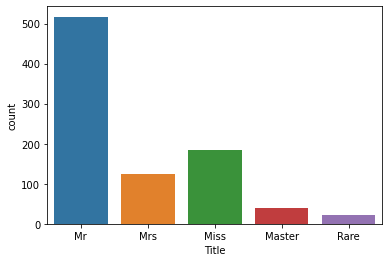

0    0
1    0
2    1
3    0
4    1
Name: IsAlone, dtype: int64


In [45]:
# Data preprocessing 

# Choose the relevant features

features = ['Pclass', 'Sex', 'Fare_Range', 'Embarked', 'Title', 'IsAlone', 'Age_Range']

# Locate the rows which have the same values in the 'SibSp', 'Parch' and 'Pclass" columns and fill the missing values with
# the median of these rows if no rows are found fill the missing value with the median of the entire 'Age' column

age_nan_indices = list(test_data[test_data['Age'].isnull()].index)

for index in age_nan_indices:
    median_age = test_data['Age'].median()
    predict_age = test_data['Age'][(test_data['SibSp'] == test_data.iloc[index]['SibSp'])
                                    & (test_data['Parch'] == test_data.iloc[index]['Parch'])
                                    & (test_data['Pclass'] == test_data.iloc[index]['Pclass'])].median()
                                       
    if np.isnan(predict_age):
        test_data['Age'].iloc[index] = median_age
    else:
        test_data['Age'].iloc[index] = predict_age

# Feature engeneering

# Make 'Fare_Range' column

test_data['Fare_Range'] = pd.cut(test_data['Fare'], bins=[0,7.91,14.45,31,120], 
                                 labels=['Low_fare','median_fare', 'Average_fare','high_fare'])

# Make 'Title' column

test_data['Title'] = [name.split(',')[1].split('.')[0].strip() for name in test_data['Name']]
test_data['Title'] = test_data['Title'].replace(['Jonkheer', 'Dr', 'Rev', 'Major', 
                                                 'Col', 'Capt', 'Don', 'the Countess', 'Lady', 'Sir', 'Dona'], 'Rare')  
test_data['Title'] = test_data['Title'].replace('Mme', 'Mrs') 
test_data['Title'] = test_data['Title'].replace(['Mlle', 'Ms'], 'Miss')
print(train_data['Title'].value_counts())
sns.countplot(data = train_data, x='Title')
plt.show()

# Make 'IsAlone' column

test_data['Family'] = test_data['SibSp'] + test_data['Parch'] + 1

test_data['IsAlone'] = 0
test_data.loc[test_data['Family'] == 1, 'IsAlone'] = 1
print(train_data['IsAlone'].head())

# Make 'Age_range' column

test_data['Age_Range'] = pd.cut(test_data['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

# Convert categorical variables into indicator variables using pd.get_dummies

new_test_data = pd.get_dummies(test_data[features])

# Assign X and y

X_train = data.drop(columns=['Survived'])
y_train = data['Survived']
X_test = new_test_data

In [43]:
# Predictive model

model_grid.fit(X_train, y_train)
predictions_grid = model_grid.predict(X_test)
output = pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : predictions_grid})
print(output)


     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


In [ ]:
output.to_csv('submission.csv', index=False)

print("Your submission was successfully saved!")